In [1]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
from matplotlib.lines import Line2D

## Defining the parameters

In [2]:
total_units = 100 # total number of nodes
average_contacts = 2 # number of contacts per unit (note that the epidemix simulator has this wrong by a factor of 2.
# When they say that average number of contacts per unit is 4, the actual number is 2)
num_inf_unit = 2 # number of exposed units at the start of the simulation
params = [3,0.25,4] # latent period = 3 days, probability of transmission = 0.25, infectious period = 4 days
num_simulation = 100 # total number of simulations
num_days = 100 # total number of days a given simulation runs for

## Average number of edges in a erdos-renyi graph $ G(N,p)  = \binom{N}{2} p$. Here $N$ is the number of nodes and $p$ is the probability of forming an edge between any two nodes. Therefore, average number of edges or contacts per node is $\frac{n-1}{2}p$.

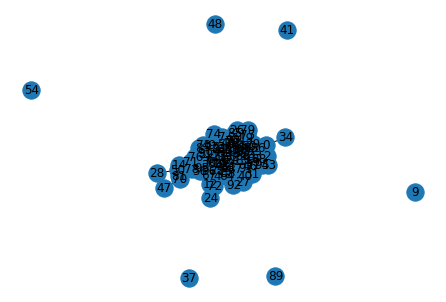

In [3]:
# Plotting a sample graph given the parameters
G = nx.erdos_renyi_graph(total_units, 2*average_contacts/(total_units-1))
nx.draw_spring(G, with_labels=True)

# Equations for the SEIR model

## $$ \frac{\mathrm{d}S_i}{\mathrm{d}t} = -\beta_iS_i $$
## $$ \frac{\mathrm{d}E_i}{\mathrm{d}t} = \beta_iS_i - \alpha E_i $$
## $$ \frac{\mathrm{d}I_i}{\mathrm{d}t} = \alpha E_i - \gamma I_i $$
## $$ \frac{\mathrm{d}R_i}{\mathrm{d}t} = \gamma I_i $$


## where $$\beta_i = \sum_{j} \beta G_{ij} I_j$$ 

## Here $ \beta $ denotes the probability of transimission. $\alpha$ denotes the rate at which exposed people become infectious. $\gamma$ denotes the recovery rate.

## To implement the above equations in an individual based model, we use the following rules.

* ### A susceptible node $i$ gets infected according to ~ $Binomial(1 - e^{-\beta_i})$.

* ### An exposed node $i$ becomes infectious after a fixed time $T_{exposed} = \frac{1}{\alpha}$, which is the time since the node got exposed. Note that we are using a fixed time here to replicate what epidemix does.

* ### An infectious node $i$ recovers or dies after a fixed time $T_{infectious} = \frac{1}{\gamma}$, which is the time since the node became infectious. Note that we are using a fixed time here to replicate what epidemix does.

# <font color='red'>Implementing the SEIR model</font>
### Each node has a ***status*** attribute which denotes the current infection state of that node. The status map is given by : 0 - susceptible (default), 1 - infectious, 2 - exposed, 3 - recovered.
### Each node also has a ***exposed_time*** and a ***infectious_time*** attribute which stores the time since exposed and the time since infectious, respectively. They are non-zero only when a given node is exposed or infectious.

In [4]:
def SEIR_model(iteration_num, graph_list, node_count, params):

    graph = graph_list[-1].copy()
 
    for _ in range(iteration_num):

        temp_node_count = node_count[-1]
        
        for node in graph:

            # when the current node is susceptible
            if graph.nodes[node]['status']==0:
                num_inf_neighbor = len([v for v in graph.neighbors(node) if graph.nodes[v]['status'] == 1])
                if np.random.random_sample() < 1 - np.exp(-params[1]*num_inf_neighbor):
                    graph.nodes[node]['status'] = 2
                    temp_node_count = [sum(x) for x in zip(temp_node_count, [-1,0,1,0])]

            # when the current node is exposed
            elif graph.nodes[node]['status']==2:
                if graph.nodes[node]['exposed_time'] >= params[0]:
                    graph.nodes[node]['status'] = 1
                    graph.nodes[node]['exposed_time'] = 0
                    temp_node_count = [sum(x) for x in zip(temp_node_count, [0,1,-1,0])]
                else:
                    graph.nodes[node]['exposed_time'] += 1

            # when the current node is infectious        
            elif graph.nodes[node]['status']==1:
                if graph.nodes[node]['infectious_time'] >= params[2]:
                    graph.nodes[node]['status'] = 3
                    graph.nodes[node]['infectious_time'] = 0
                    temp_node_count = [sum(x) for x in zip(temp_node_count, [0,-1,0,1])]
                else:
                    graph.nodes[node]['infectious_time'] += 1

        node_count.append(temp_node_count)
        graph_list.append(graph.copy())

    return graph_list, node_count

In [5]:
# Choosing the graph
G = nx.erdos_renyi_graph(total_units, 2*average_contacts/(total_units-1))

# Initiating the graph attributes
status_array = dict(G.nodes(data='status', default=0))
nx.set_node_attributes(G, status_array, 'status')
exposed_array = dict(G.nodes(data='exposed_time', default=0))
nx.set_node_attributes(G, exposed_array, 'exposed_time')
infectious_array = dict(G.nodes(data='infectious_time', default=0))
nx.set_node_attributes(G, infectious_array, 'infectious_time')

## Running the simulation

In [6]:
compiled_g_list = []
compiled_node_count = []

for _ in range(num_simulation):
    
    G_use = G.copy()
    
    # choosing the infected units at the beginning
    
    exposed_nodes = np.random.randint(total_units, size=(num_inf_unit))
    for i in exposed_nodes:
        G_use.nodes[i]['status']=2

    graph_list = [G_use.copy()]
    
    
    init_node_count = [0,0,0,0]
    for node in G_use:
        node_stat = G_use.nodes[node]['status']
        init_node_count[node_stat] += 1
    node_count = [init_node_count]
    
    # running the SEIR model
    g_list, node_count = SEIR_model(num_days, graph_list, node_count, params)
    compiled_g_list.append(g_list)
    compiled_node_count.append(node_count)

In [7]:
%matplotlib inline

## Showing the video of how the epidemics spreads for one of the simulations

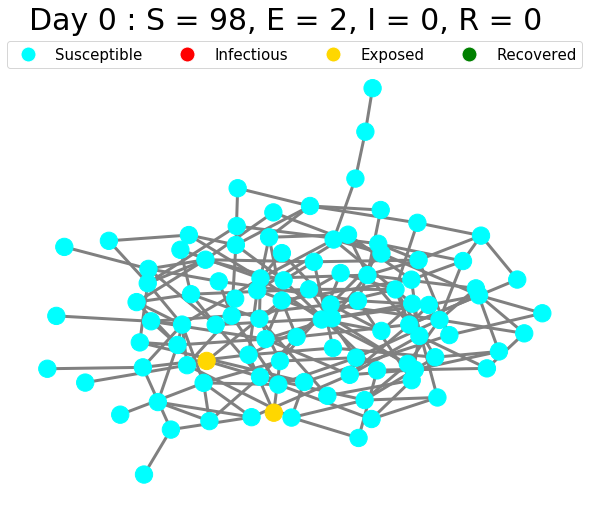

In [8]:
color_ref = ['aqua','red','gold','g']
fig, ax = plt.subplots(figsize=(10,8))
#fig.set_facecolor("#00000F")
# Animation funciton
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Susceptible', markerfacecolor='aqua', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Infectious', markerfacecolor='r', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Exposed', markerfacecolor='gold', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Recovered', markerfacecolor='g', markersize=15)]

sim_num = 1
pos = nx.kamada_kawai_layout(compiled_g_list[sim_num][0])
def animate(i):
    ax.clear()
    plot_graph = compiled_g_list[sim_num][i].copy()
    color_map = [color_ref[plot_graph.nodes[k]['status']] for k in plot_graph]
    nx.draw(plot_graph, pos, node_color=color_map, with_labels=False, edge_color="gray", width = 3)
    #limits=plt.axis('on') # turns on axis
    fig.suptitle(f"Day {i} : S = {node_count[i][0]}, E = {node_count[i][2]}, I = {node_count[i][1]}, R = {node_count[i][3]}", fontsize=30)
    ax.legend(handles=legend_elements, loc="upper center",
          bbox_to_anchor=(0.5, 1.07), ncol=4, fontsize = 15)
    
    
anim = animation.FuncAnimation(fig, animate, frames=20, interval=1000, repeat=True)
                     
HTML(anim.to_html5_video())

## Plotting how the total number of each infection state evolves over time (average over all simulations)

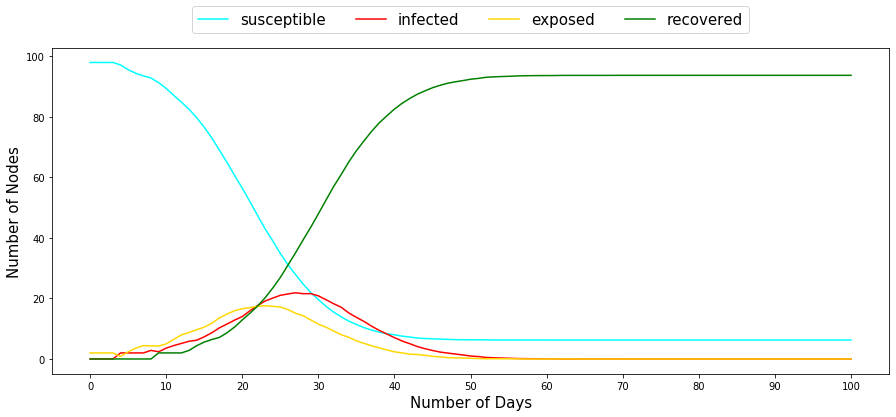

In [9]:
 average_node_count = np.mean(np.asarray(compiled_node_count),axis=0)
plt.figure(figsize=(15,6))
plt.plot(range(0,len(average_node_count)),[v[0] for v in average_node_count], label='susceptible', color = 'aqua')
plt.plot(range(0,len(average_node_count)),[v[1] for v in average_node_count], label='infected', color = 'red')
plt.plot(range(0,len(average_node_count)),[v[2] for v in average_node_count], label='exposed', color = 'gold')
plt.plot(range(0,len(average_node_count)),[v[3] for v in average_node_count], label='recovered', color = 'green')
plt.xlabel('Number of Days', fontsize = 15)
plt.ylabel('Number of Nodes', fontsize = 15)
plt.xticks(np.arange(0,len(node_count),10))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol = 4, fontsize = 15)